<a href="https://colab.research.google.com/github/nur1801/Custom-OCR-CRNN/blob/master/custom-ocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
! pip install -q kaggle

In [6]:
! mkdir ~/.kaggle

In [11]:
! cp /content/kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json

In [13]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alizahidraja/captcha-data")

print("Path to dataset files:", path)

100%|██████████| 8.72M/8.72M [00:01<00:00, 8.19MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/alizahidraja/captcha-data/versions/1


In [15]:
!mv $path /content/

In [62]:
import glob
import os
import string
from pathlib import Path

from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import resnet18
import matplotlib.pyplot as plt
from collections.abc import Iterable

from IPython.display import clear_output
%matplotlib inline
# plt.style.use('seaborn') # Commented out due to error: 'seaborn' is not a valid style.
# You can check available styles using `plt.style.available` and choose one from the list.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [22]:
for dirname, _, filenames in os.walk('/content/1/data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/content/1/data/train/5gcd3.png
/content/1/data/train/eppg3.png
/content/1/data/train/p4pde.png
/content/1/data/train/5p3mm.png
/content/1/data/train/62nb3.png
/content/1/data/train/53wb8.png
/content/1/data/train/56m6y.png
/content/1/data/train/my84e.png
/content/1/data/train/mdxpn.png
/content/1/data/train/4dgf7.png
/content/1/data/train/feyc8.png
/content/1/data/train/7pn5g.png
/content/1/data/train/4dw3w.png
/content/1/data/train/yd3m3.png
/content/1/data/train/w2yp7.png
/content/1/data/train/n2c85.jpg
/content/1/data/train/2b827.png
/content/1/data/train/4gycb.png
/content/1/data/train/y2ye8.png
/content/1/data/train/d8dce.png
/content/1/data/train/ffd6p.png
/content/1/data/train/byc82.png
/content/1/data/train/b3xpn.png
/content/1/data/train/36w25.png
/content/1/data/train/nxf2c.jpg
/content/1/data/train/e72cd.png
/content/1/data/train/ndg2b.png
/content/1/data/train/78eec.png
/content/1/data/train/nngxc.png
/content/1/data/train/fwxdp.png
/content/1/data/train/gnc3n.png
/content

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)

In [63]:
def plot_loss(epoch: int,
              train_losses: list,
              val_losses: list,
              n_steps: int = 100):

    # clear previous graph
    clear_output(True)
    # making titles
    train_title = f'Epoch:{epoch} | Train Loss:{np.mean(train_losses[-n_steps:]):.6f}'
    val_title = f'Epoch:{epoch} | Val Loss:{np.mean(val_losses[-n_steps:]):.6f}'

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].plot(train_losses)
    ax[1].plot(val_losses)

    ax[0].set_title(train_title)
    ax[1].set_title(val_title)

    plt.show()

def print_prediction(model, dataset, device, label_converter):
    idx = np.random.randint(len(dataset))
    path = dataset.pathes[idx]

    with torch.no_grad():
        model.eval()
        img, target_text = dataset[idx]
        img = img.unsqueeze(0)
        logits = model(img.to(device))

    pred_text = decode_prediction(logits.cpu(), label_converter)

    img = np.asarray(Image.open(path).convert('L'))
    title = f'Truth: {target_text} | Pred: {pred_text}'
    plt.imshow(img)
    plt.title(title)
    plt.axis('off');

In [64]:
class strLabelConverter(object):

    def __init__(self, alphabet: str, ignore_case: bool = True):
        self._ignore_case = ignore_case
        if self._ignore_case:
            alphabet = alphabet.lower()
        self.alphabet = alphabet + '-'  # for `-1` index

        self.char2idx = {}
        for i, char in enumerate(alphabet):
            self.char2idx[char] = i + 1
        self.idx2char = {idx: char for char, idx in self.char2idx.items()}

    def encode(self, text):
        if isinstance(text, str):
            text = [
                self.char2idx[char.lower() if self._ignore_case else char]
                for char in text
            ]
            length = [len(text)]
        elif isinstance(text, Iterable):
            length = [len(s) for s in text]
            text = ''.join(text)
            text, _ = self.encode(text)
        return (torch.IntTensor(text), torch.IntTensor(length))

    def decode(self, t, length, raw=False):
        if length.numel() == 1:
            length = length[0]
            assert t.numel() == length, "text with length: {} does not match declared length: {}".format(t.numel(), length)
            if raw:
                return ''.join([self.alphabet[i - 1] for i in t])
            else:
                char_list = []
                for i in range(length):
                    if t[i] != 0 and (not (i > 0 and t[i - 1] == t[i])):
                        char_list.append(self.alphabet[t[i] - 1])
                return ''.join(char_list)
        else:
            # batch mode
            assert t.numel() == length.sum(), "texts with length: {} does not match declared length: {}".format(t.numel(), length.sum())
            texts = []
            index = 0
            for i in range(length.numel()):
                l = length[i]
                texts.append(
                    self.decode(
                        t[index:index + l], torch.IntTensor([l]), raw=raw))
                index += l
        return texts


def decode_prediction(logits: torch.Tensor,
                      label_converter: strLabelConverter) -> str:
    tokens = logits.softmax(2).argmax(2)
    tokens = tokens.squeeze(1).numpy()

    # convert tor stings tokens
    tokens = ''.join([label_converter.idx2char[token]
                      if token != 0  else '-'
                      for token in tokens])
    tokens = tokens.split('-')

    # remove duplicates
    text = [char
            for batch_token in tokens
            for idx, char in enumerate(batch_token)
            if char != batch_token[idx-1] or len(batch_token) == 1]
    text = ''.join(text)
    return text

In [65]:
class blockCNN(nn.Module):
    def __init__(self, in_nc, out_nc, kernel_size, padding, stride=1):
        super(blockCNN, self).__init__()
        self.in_nc = in_nc
        self.out_nc = out_nc
        self.kernel_size = kernel_size
        self.padding = padding
        # layers
        self.conv = nn.Conv2d(in_nc, out_nc,
                              kernel_size=kernel_size,
                              stride=stride,
                              padding=padding)
        self.bn = nn.BatchNorm2d(out_nc)

    def forward(self, batch, use_bn=False, use_relu=False,
                use_maxpool=False, maxpool_kernelsize=None):
        batch = self.conv(batch)
        if use_bn:
            batch = self.bn(batch)
        if use_relu:
            batch = F.relu(batch)
        if use_maxpool:
            assert maxpool_kernelsize is not None
            batch = F.max_pool2d(batch, kernel_size=maxpool_kernelsize, stride=2)
        return batch

class blockRNN(nn.Module):
    def __init__(self, in_size, hidden_size, out_size, bidirectional, dropout=0):
        super(blockRNN, self).__init__()
        self.in_size = in_size
        self.hidden_size = hidden_size
        self.out_size = out_size
        self.bidirectional = bidirectional
        # layers
        self.gru = nn.GRU(in_size, hidden_size, bidirectional=bidirectional)

    def forward(self, batch, add_output=False):
        batch_size = batch.size(1)
        outputs, hidden = self.gru(batch)
        out_size = int(outputs.size(2) / 2)
        if add_output:
            outputs = outputs[:, :, :out_size] + outputs[:, :, out_size:]
        return outputs

## <center>  Dataset

In [66]:
class CaptchaDataset(Dataset):
    def __init__(self, img_dir: str):
        pathes = os.listdir(img_dir)
        abspath = os.path.abspath(img_dir)
        self.img_dir = img_dir
        self.pathes = [os.path.join(abspath, path) for path in pathes]
        self.list_transforms = transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        return len(self.pathes)

    def __getitem__(self, idx):
        path = self.pathes[idx]
        text = self.get_filename(path)
        img = Image.open(path).convert('RGB')
        img = self.transform(img)
        return img, text

    def get_filename(self, path: str) -> str:
        return os.path.basename(path).split('.')[0].lower().strip()

    def transform(self, img) -> torch.Tensor:
        return self.list_transforms(img)

## <center> Dataset Params

In [67]:
TRAIN_DIR = Path('/content/1/data/train')
VAL_DIR = Path('/content/1/data/val')
BATCH_SIZE = 8
N_WORKERS = 2

In [68]:
alphabet = string.ascii_lowercase + string.digits
label_converter = strLabelConverter(alphabet)
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789'

In [69]:
train_dataset = CaptchaDataset(TRAIN_DIR)
val_dataset = CaptchaDataset(VAL_DIR)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              num_workers=N_WORKERS, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                            num_workers=N_WORKERS, shuffle=False)

In [70]:
imgs, texts = next(iter(val_dataloader))
print(imgs.shape, len(texts))

torch.Size([8, 3, 50, 200]) 8


## <center> Model

In [71]:
def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [72]:
class CRNN(nn.Module):
    def __init__(self, hidden_size: int,
                 vocab_size: int,
                 bidirectional: bool = True,
                 dropout: float = 0.5):
        super(CRNN, self).__init__()
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.bidirectional = bidirectional
        # make layers
        # convolutions
        resnet = resnet18(pretrained=True)
        modules = list(resnet.children())[:-3]
        self.resnet = nn.Sequential(*modules)
        #PRETRAINED^



        self.cn6 = blockCNN(256, 256, kernel_size=3, padding=1)
        # RNN + Linear
        self.linear1 = nn.Linear(1024, 256)
        self.gru1 = blockRNN(256, hidden_size, hidden_size,
                             dropout=dropout,
                             bidirectional=bidirectional)
        self.gru2 = blockRNN(hidden_size, hidden_size, vocab_size,
                             dropout=dropout,
                             bidirectional=bidirectional)
        self.linear2 = nn.Linear(hidden_size * 2, vocab_size)

    def forward(self, batch: torch.Tensor):
        batch_size = batch.size(0)
        # convolutions
        batch = self.resnet(batch)
        batch = self.cn6(batch, use_relu=True, use_bn=True)
        # make sequences of image features
        batch = batch.permute(0, 3, 1, 2)
        n_channels = batch.size(1)
        batch = batch.view(batch_size, n_channels, -1)
        batch = self.linear1(batch)
        # rnn layers
        batch = self.gru1(batch, add_output=True)
        batch = self.gru2(batch)
        # output
        batch = self.linear2(batch)
        batch = batch.permute(1, 0, 2)
        return batch

## <center>  Model Parameters and Initialization

In [73]:
hidden_size = 256
vocab_size = len(alphabet) + 1 # extra character for blank symbol
bidirectional = True
dropout = 0.1
weight_decay = 1e-5
momentum = 0.9
clip_norm = 5
max_epoch = 50
print(vocab_size)

37


In [74]:
crnn = CRNN(hidden_size=hidden_size, vocab_size=vocab_size,
            bidirectional=bidirectional, dropout=dropout).to(device)
crnn(imgs.to(device)).shape

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([13, 8, 37])

In [75]:
lr = 0.02
optimizer = torch.optim.SGD(crnn.parameters(), lr=lr, nesterov=True,
                            weight_decay=weight_decay, momentum=momentum)
critertion = nn.CTCLoss(blank=0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)

In [76]:
def validation(model, val_losses, label_converter):
    with torch.no_grad():
        model.eval()
        for batch_img, batch_text in val_dataloader:
            logits = crnn(batch_img.to(device))
            val_loss = calculate_loss(logits, batch_text, label_converter)
            val_losses.append(val_loss.item())
    return val_losses

In [77]:
def calculate_loss(logits, texts, label_converter):
    # get infomation from prediction
    device = logits.device
    input_len, batch_size, vocab_size = logits.size()
    # encode inputs
    logits = logits.log_softmax(2)
    encoded_texts, text_lens = label_converter.encode(texts)
    logits_lens = torch.full(size=(batch_size,), fill_value=input_len, dtype=torch.int32)
    # calculate ctc
    loss = critertion(logits, encoded_texts,
                      logits_lens.to(device), text_lens)
    return loss

## <center> Training

In [78]:
epoch = 0

In [79]:
train_losses = []
val_losses = []
val_epoch_len = len(val_dataset) // BATCH_SIZE
val_epoch_len

26

In [ ]:
try:
    while epoch <= max_epoch:
        crnn.train()
        for idx, (batch_imgs, batch_text) in enumerate(train_dataloader):
            optimizer.zero_grad()
            logits = crnn(batch_imgs.to(device))
            # calculate loss
            train_loss = calculate_loss(logits, batch_text, label_converter)
            if np.isnan(train_loss.detach().cpu().numpy()):
                continue
            train_losses.append(train_loss.item())
            # make backward
            train_loss.backward()

            nn.utils.clip_grad_norm_(crnn.parameters(), clip_norm)
            optimizer.step()

        val_losses = validation(crnn, val_losses, label_converter)

        # printing progress
        plot_loss(epoch, train_losses, val_losses)
        print_prediction(crnn, val_dataset, device, label_converter)

        scheduler.step(val_losses[-1])
        epoch += 1
except KeyboardInterrupt:
    pass

In [55]:
# saving model
torch.save(crnn.state_dict(), '/content/crnn.pt')

#### <center> Calculating Accuracy and printing prediction

In [56]:
def acc_calc(model, dataset, label_converter) -> float:
    acc = 0
    with torch.no_grad():
        model.eval()
        for idx in range(len(dataset)):
            img, text = dataset[idx]
            logits = model(img.unsqueeze(0).to(device))
            pred_text = decode_prediction(logits.cpu(), label_converter)

            if pred_text == text:
                acc += 1

    return acc / len(dataset)

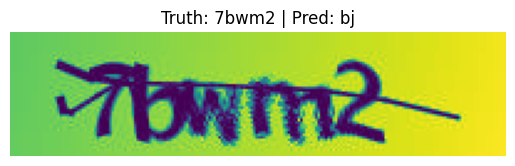

In [57]:
print_prediction(crnn, val_dataset, device, label_converter)

In [58]:
val_acc = acc_calc(crnn, val_dataset, label_converter)
train_acc = acc_calc(crnn, train_dataset, label_converter)
print('Validaton Accuracy: ', val_acc)
print('Training Accuracy: ', train_acc)

Validaton Accuracy:  0.0
Training Accuracy:  0.0


In [ ]:
crnn

CRNN(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   